<a href="https://colab.research.google.com/github/rodjfg/los-fabulosos-pixelotls/blob/master/glm_Correct_vs_Incorrect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Correct vs Incorrect

In [6]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [7]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [8]:
# get data
alldat = load_raw_data()

In [9]:
def select_by_outcome(dat, feedback_type: str = 'correct'):
    '''Find indices of trials with the specified outcome (correct, incorrect) in the dataset provided from a single experiment. 
       Correct = Rewarded, Incorrect = punished. Note that succesful no-go trials indices are also included.
    Args:
        dat (dict): data dictionary from a single experiment. For example dat = alldat[11] in the example notebook.
        feedback_type (str): str specifying outcome. "correct", "incorrect"
    Returns:
        indices (1D array): array of indices from trials.'''

    if feedback_type == 'correct':
        indices = np.where(dat['feedback_type'] > 0)[0]
    elif feedback_type == 'incorrect':
        indices = np.where(dat['feedback_type'] < 0)[0]
  
    else:
        raise Warning('wrong response_type input, choose: correct or incorrect')

    return indices

In [28]:
selected_regions = ["VISp"]
gaussfilter = True
gauss_sigma = 1

samples = np.empty((0,250))
y = np.empty((0,))

for dat in alldat:
  dt = dat['bin_size']

  neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)

  if len(neurons_indices_in_area) > 0:

    correct_trials   = select_by_outcome(dat, feedback_type = 'correct')   # trials in which mouse was correct   (trials in which the animals was reinforced, water reward)
    incorrect_trials = select_by_outcome(dat, feedback_type = 'incorrect') # trials in which mouse was incorrect (trials in which the animals was punished, whit noise burst)
    no_go_trials     = select_by_contrast(dat, contrast_pair = (0, 0))     # no-go trials indices

    correct_trials   = [x for x in correct_trials if x not in no_go_trials]   # we exclude no go trials
    incorrect_trials = [x for x in incorrect_trials if x not in no_go_trials] # we exclude no go trials

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left
    correct_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,correct_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
    incorrect_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,incorrect_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)

    # Find minimum number of samples that can be extracted from both conditions:
    
    # ALternative 1, we feed the model with equal number of positive and negative trials  # Thus, we find which
    # one is the limitting condition and select only as many trials from the non-limiting condition. (this reduces our dataset substantially) 
   
    # n_min   = min(correct_firing_rates.shape[0],incorrect_firing_rates.shape[0])
    # samples = np.concatenate((samples,correct_firing_rates[:n_min,...]),axis=0)  
    # samples = np.concatenate((samples,incorrect_firing_rates[:n_min,...]),axis=0)
    
    # Alternative 2, we feed the model with all the trials. This teaches better the model to recognise correct than incorrect trials.
    samples = np.concatenate((samples,correct_firing_rates),axis=0)
    samples = np.concatenate((samples,incorrect_firing_rates),axis=0)
    
    # Create output variable to train the GLM. 1: when mouse was correct, 0: when mouse was incorrect
    y = np.concatenate( (y, np.ones(correct_firing_rates.shape[0])) )
    y = np.concatenate( (y, np.zeros(incorrect_firing_rates.shape[0])) )

In [29]:
y.shape, samples.shape

((2455,), (2455, 250))

TRAIN AND TEST SPLIT

In [30]:
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)

In [37]:
# C: float, default=1.0, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l1', solver='saga', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train) # crossvalidation
# clf = LogisticRegression(penalty='l1', C =1.0, solver='saga', tol=0.0001, max_iter=50000, random_state=42).fit(samples_train, y_train)

In [38]:
clf.score(samples_test,y_test)

0.6938053097345133

In [39]:
clf.score(samples_train,y_train)

0.7111111111111111

In [41]:
print(clf.C_) # OPtimal C value as specified with Crossvalidation

[0.01]


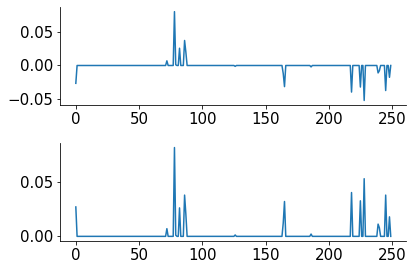

In [42]:
plt.subplot(211)
plt.plot(clf.coef_[0,:])
plt.subplot(212)
plt.plot(np.abs(clf.coef_[0,:]))
plt.show()